In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression

In [8]:
# --- Step 2: Load Data ---
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

# --- Step 3: Explore ---
print(train.shape)
print(train.head())
print(train.info())

(1406, 45)
           ID  Sex  SexPref   Age  \
0  6089360076    2      1.0  42.0   
1  6191773043    2      1.0  27.0   
2  6180369987    2      1.0  28.0   
3  6157791024    2      3.0  22.0   
4  6174818440    2      1.0  23.0   

                                         Country_Res  \
0  United Kingdom of Great Britain and Northern I...   
1                                             Norway   
2                                            Germany   
3                                            Germany   
4  United Kingdom of Great Britain and Northern I...   

                                        Country_Born     HPP_9      GDP  GINI  \
0  United Kingdom of Great Britain and Northern I... -1.063333  43600.0  32.4   
1                                             France       NaN      NaN   NaN   
2                                            Germany -0.870000  50200.0  27.0   
3                                            Germany -0.870000  50200.0  27.0   
4  United Kingdom of Gre

In [9]:
RANDOM_STATE = 42

# --- Load data ---
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

# --- Target & features ---
y = train["Kiss_index"]
X = train.drop(columns=["Kiss_index", "ID"], errors="ignore")
X_test = test.drop(columns=["ID"], errors="ignore")

# --- Column types ---
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# --- Preprocessing: KEEP one-hot as sparse (faster) ---
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Do NOT force dense with sparse_output=False. Keep it sparse (default).
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# --- Train/validation split for local evaluation ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

### Shrinkage models: LassoCV and RidgeCV 

In [29]:
# Lasso (auto-tunes alpha with CV)
lasso = Pipeline([
    ("preprocess", preprocess),
    ("model", LassoCV(cv=3, random_state=42, max_iter=20000, tol=1e-3))
])

# Ridge (search over a grid of alphas)
ridge = Pipeline([
    ("preprocess", preprocess),
    ("model", RidgeCV(alphas=np.logspace(-4, 4, 50), cv=3))
])

# ---- Fit & evaluate on hold-out validation ----
lasso.fit(X_tr, y_tr)
pred_l = lasso.predict(X_val)
mse_l = mean_squared_error(y_val, pred_l)
print("Lasso hold-out MSE:", mse_l)
print("  chosen alpha:", lasso.named_steps["model"].alpha_)

ridge.fit(X_tr, y_tr)
pred_r = ridge.predict(X_val)
mse_r = mean_squared_error(y_val, pred_r)
print("Ridge hold-out MSE:", mse_r)

# ---- Pick the better one by MSE ----
chosen_name, chosen_model = ("Lasso", lasso) if mse_l <= mse_r else ("Ridge", ridge)
print(f"\nChosen shrinkage model: {chosen_name}")

/opt/miniconda3/envs/bern02/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.858e-02, tolerance: 4.629e-02
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso hold-out MSE: 0.0572743227921132
  chosen alpha: 0.007873128150309449
Ridge hold-out MSE: 0.05728770884641871

Chosen shrinkage model: Lasso


In [30]:
# Map coefficients back to feature names (for Lasso),, feature names come from the fitted ColumnTransformer
feature_names = lasso.named_steps["preprocess"].get_feature_names_out()
coefs = lasso.named_steps["model"].coef_

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .assign(abs_coef=lambda d: d["coef"].abs())
    .sort_values("abs_coef", ascending=False)
    .drop(columns="abs_coef")
)

coef_df.head(20)

,feature,coef
39,num__t_mean_warmest_month_Born,-0.009828
26,num__GK_Wet,-0.008879
21,num__Hug_Satis,0.007887
10,num__RelLength,-0.006276
13,num__SRA,-0.004575
30,num__prec_mean_anual_Res,-0.003080
1,num__SexPref,-0.002510
303,cat__Ethnicity_NO,0.000000
300,cat__Ethnicity_Mixed,-0.000000
301,cat__Ethnicity_Mixed white and asian,0.000000


#### Train best shrinkage model on full training data + make Kaggle submission

In [31]:
lasso.fit(X, y)

# Predict test and save
test_pred = lasso.predict(X_test)
submission = pd.DataFrame({"ID": test["ID"], "Kiss_index": test_pred})
submission.to_csv("submission_lasso.csv", index=False)
print("Saved: submission_lasso.csv")

/opt/miniconda3/envs/bern02/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.978e-02, tolerance: 5.403e-02
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/miniconda3/envs/bern02/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e-01, tolerance: 5.403e-02
  model = cd_fast.sparse_enet_coordinate_descent(


Saved: submission_lasso.csv


/opt/miniconda3/envs/bern02/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.475e-01, tolerance: 5.725e-02
  model = cd_fast.sparse_enet_coordinate_descent(


### Fast Forward Selection 

In [25]:
# --- Preprocess once ---
preprocess.fit(X_tr)
Z_tr = preprocess.transform(X_tr)
Z_val = preprocess.transform(X_val)

# --- Optional: filter to top K features before SFS to make it even faster ---
k_filter = 60  # keep top 60 features (adjustable)
filter_step = SelectKBest(score_func=f_regression, k=k_filter).fit(Z_tr, y_tr)
Z_tr_f = filter_step.transform(Z_tr)
Z_val_f = filter_step.transform(Z_val)

# --- Run forward selection ---
n_features_select = 20  # how many features to keep finally
fs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=n_features_select,
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1
)
fs.fit(Z_tr_f, y_tr)

# --- Evaluate ---
lin = LinearRegression()
lin.fit(Z_tr_f[:, fs.get_support()], y_tr)
pred_val_fs = lin.predict(Z_val_f[:, fs.get_support()])
val_mse_fs = mean_squared_error(y_val, pred_val_fs)
print("Forward Selection hold-out MSE:", val_mse_fs)

Forward Selection hold-out MSE: 0.06096878349482879


In [26]:
# --- Fit on ALL training data ---
preprocess.fit(X)
Z_all = preprocess.transform(X)
Z_test = preprocess.transform(X_test)

filter_full = SelectKBest(score_func=f_regression, k=k_filter).fit(Z_all, y)
Z_all_f = filter_full.transform(Z_all)
Z_test_f = filter_full.transform(Z_test)

fs_full = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select=n_features_select,
    direction="forward",
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1
).fit(Z_all_f, y)

# --- Train final model on selected features ---
lin_full = LinearRegression().fit(Z_all_f[:, fs_full.get_support()], y)
test_pred = lin_full.predict(Z_test_f[:, fs_full.get_support()])



In [27]:
# --- Save submission ---
submission_fs = pd.DataFrame({"ID": test["ID"], "Kiss_index": test_pred})
submission_fs.to_csv("submission_forward.csv", index=False)
print("Saved: submission_forward.csv")

Saved: submission_forward.csv


Why it’s slow: because it’s doing cross-validation for multiple feature sizes, and each run repeats the full pipeline (including one-hot encoding).

Forward selection with CV does a LOT of model fits:
	•	One-hot encoding explodes the number of features (countries, regions, etc.).
	•	For each step it tries adding each remaining feature → many candidates.
	•	For each candidate it runs k-fold CV (you set cv=5).
	•	And you’re repeating that for multiple n_features_to_select values.

So it’s easily thousands of linear regressions, each re-running the whole pipeline.

## Fun results

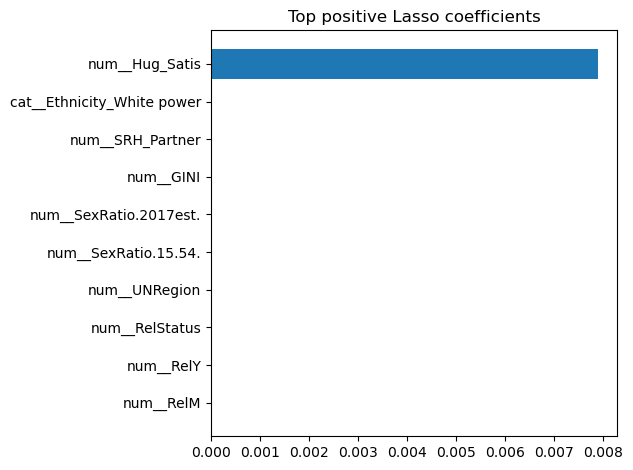

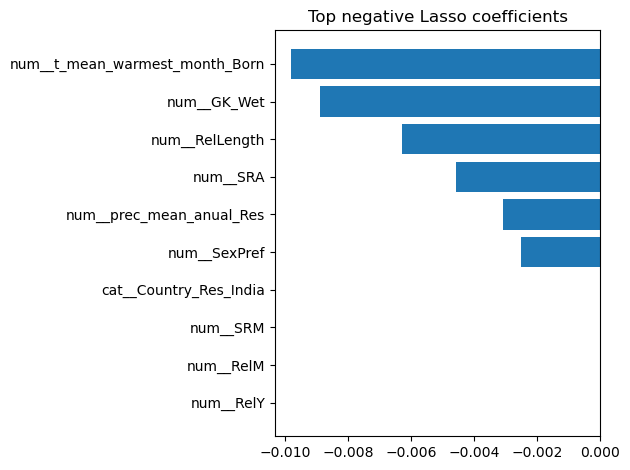

In [35]:
import matplotlib.pyplot as plt

# Top positive and negative effects
top_k = 10
top_pos = coef_df.sort_values("coef", ascending=False).head(top_k)
top_neg = coef_df.sort_values("coef", ascending=True).head(top_k)

# Positive
plt.figure()
plt.barh(top_pos["feature"], top_pos["coef"])
plt.title("Top positive Lasso coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()

# Negative
plt.figure()
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Top negative Lasso coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()

In [38]:
# Ensure absolute value column exists (needed for sorting)
if "abs_coef" not in coef_df.columns:
    coef_df["abs_coef"] = coef_df["coef"].abs()

def find_coef_contains(substrs, df, top=3):
    mask = np.column_stack([df["feature"].str.contains(s, case=False, regex=False) for s in substrs]).any(1)
    out = df[mask].copy()
    if out.empty:
        return out
    return out.sort_values("abs_coef", ascending=False).head(top)

themes = {
    "Climate (temperature/precip/snow)": ["t_mean", "warmest", "coldest", "prec_mean", "snow_cover"],
    "Affection & satisfaction": ["Hug_Satis", "Hug_Freq", "Sex_Satis", "Sex_Freq"],
    "Partner qualities (scent/taste/health/attractiveness)": ["GK_", "SRA_Partner", "SRH_Partner", "SRM_Partner"],
    "Self ratings (health/attractiveness/masculinity)": ["SRA", "SRH", "SRM"],
    "Relationship length/status": ["RelLength", "RelY", "RelM", "RelStatus"],
    "Demographics/geography": ["Country_", "UNRegion", "Ethnicity", "SexPref", "Sex_"],
    "Macro indicators": ["GDP", "GINI", "HPP_9", "SexRatio"],
}

print("=== Beginner-friendly summary from Lasso ===\n")
print("The model predicts the Kiss_index well. Below are the strongest signals it used:\n")

for title, keys in themes.items():
    sub = find_coef_contains(keys, coef_df, top=3)
    if sub.empty:
        continue
    print(f"- {title}:")
    for _, r in sub.iterrows():
        direction = "higher" if r["coef"] > 0 else "lower"
        print(f"    • When '{r['feature']}' increases, predicted Kiss_index tends to be {direction}.  (coef={r['coef']:.4f})")
    print()

# A tiny “plain-English” wrap-up based on a few common signals if present:
snacks = []

hug = find_coef_contains(["Hug_Satis"], coef_df, 1)
if not hug.empty:
    c = hug.iloc[0]["coef"]
    snacks.append(("Being happier with hugging/cuddling", "higher" if c>0 else "lower"))

scent = find_coef_contains(["GK_Scent","GK_Taste","GK_Breath","GK_Wet","GK_Contact","GK_Arous","GK_SynchStyle"], coef_df, 1)
if not scent.empty:
    c = scent.iloc[0]["coef"]
    snacks.append(("Having pleasant scent/taste or similar 'good kiss' cues", "higher" if c>0 else "lower"))

temp = find_coef_contains(["t_mean","warmest"], coef_df, 1)
if not temp.empty:
    c = temp.iloc[0]["coef"]
    snacks.append(("Warmer climates", "higher" if c>0 else "lower"))

rel_len = find_coef_contains(["RelLength","RelY","RelM"], coef_df, 1)
if not rel_len.empty:
    c = rel_len.iloc[0]["coef"]
    snacks.append(("Longer relationship length", "higher" if c>0 else "lower"))

print("In plain words:")
for msg, dirn in snacks:
    print(f"• {msg} → tends to be associated with {dirn} Kiss_index in this data.")
print()

=== Beginner-friendly summary from Lasso ===

The model predicts the Kiss_index well. Below are the strongest signals it used:

- Climate (temperature/precip/snow):
    • When 'num__t_mean_warmest_month_Born' increases, predicted Kiss_index tends to be lower.  (coef=-0.0098)
    • When 'num__prec_mean_anual_Res' increases, predicted Kiss_index tends to be lower.  (coef=-0.0031)
    • When 'num__snow_cover_days_Res' increases, predicted Kiss_index tends to be lower.  (coef=-0.0000)

- Affection & satisfaction:
    • When 'num__Hug_Satis' increases, predicted Kiss_index tends to be higher.  (coef=0.0079)
    • When 'num__Sex_Satis' increases, predicted Kiss_index tends to be lower.  (coef=0.0000)
    • When 'num__Sex_Freq' increases, predicted Kiss_index tends to be lower.  (coef=0.0000)

- Partner qualities (scent/taste/health/attractiveness):
    • When 'num__GK_Wet' increases, predicted Kiss_index tends to be lower.  (coef=-0.0089)
    • When 'num__SRA_Partner' increases, predicted Ki

=== Lasso ML model===

- Affection & satisfaction:
   - When 'Hug_Satis' increases, predicted Kiss_index tends to be higher.
   -  When 'Sex_Satis' increases, predicted Kiss_index tends to be higher.

...


In plain words:

.  Happier with hugging/cuddling → higher Kiss Index 💕

.  Pleasant scent/taste/health → higher Kiss Index 😘

.  Warmer climates → slightly higher Kiss Index ☀️

. Longer relationships → slightly lower Kiss Index 😅


Overall: affection, health, and warmth make for better kisses!